<a href="https://colab.research.google.com/github/scottcohn97/micromobility/blob/main/atx_micromobility_explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATX Micromobility

In [12]:
# run for tidy census
system("sudo apt-get install libgdal-dev libproj-dev")

In [91]:
# run  due to a missing udunits2 system library for units pkg
system("sudo apt-get install libudunits2-dev")

In [ ]:
library(devtools)
remotes::install_github("r-quantities/units", dependencies = TRUE)
remotes::install_github("walkerke/tidycensus", dependencies = TRUE)

In [ ]:
install.packages("ggmap")
install.packages("ggthemes")
install.packages("RSocrata")

In [93]:
# libs
library(tidyverse)
library(lubridate)
library(tidycensus)
library(ggthemes)
library(jsonlite)
library(RSocrata)
library(ggmap)
library(sf)

Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.

Please cite ggmap if you use it! See citation("ggmap") for details.



### API Keys

In [109]:
# register google static map API
register_google(key = "ADD KEY HERE")

# register census API
census_api_key(key = "ADD KEY HERE")

## Import data
... and some prelim graphs

Shared micromobility data [explorer](http://dockless.austintexas.io/)

Shared micromobility [dashboard](https://transportation.austintexas.io/micromobility-data/)


In [76]:
# TODO Elimate limit=1000

# get 2020 data
sql_import <- "?$where=Year==2020&$limit=1000000"

df_2020 <- fromJSON(
  # https://doi.org/10.26000/030.000003
  paste0("https://data.austintexas.gov/resource/7d8e-dm7r.json", sql_import)
  ) 

In [79]:
df_2020 %>% nrow()

[1] 1000000

In [24]:
df_2020 %>% 
  colnames()

[1] "trip_id"                "device_id"              "vehicle_type"          
 [4] "trip_duration"          "trip_distance"          "start_time"            
 [7] "end_time"               "modified_date"          "month"                 
[10] "hour"                   "day_of_week"            "council_district_start"
[13] "council_district_end"   "year"                   "census_geoid_start"    
[16] "census_geoid_end"

In [77]:
# sep to group by date
df_2020 <- df_2020 %>%
  # !! could use lubridate to floor instead
  mutate(modified_date_notime = as.Date(modified_date))

In [50]:
typeof(as.Date(str(df_2020$modified_date_notime)))

 Date[1:50000], format: "2020-04-19" "2020-04-19" "2020-04-19" "2020-04-19" "2020-04-19" ...


[1] "double"

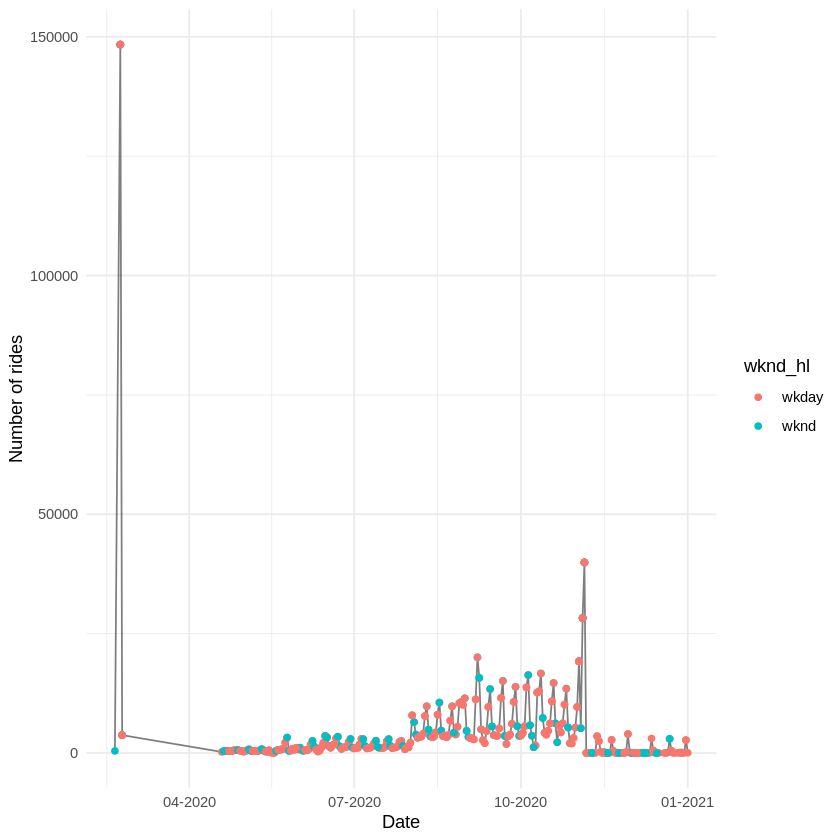

In [78]:
df_2020 %>% 
  group_by(modified_date_notime) %>%
  add_count() %>%
  select(modified_date_notime, n, day_of_week) %>%
  mutate(wknd_hl = if_else(day_of_week %in% c(0, 6), "wknd", "wkday")) %>%
  distinct() %>%
  #head()
  ggplot() + 
    geom_line(aes(x = modified_date_notime, y = n), alpha = 0.5) + 
    geom_point(aes(x = modified_date_notime, y = n, color = wknd_hl)) +
    scale_x_date(date_labels = "%m-%Y") +
    labs(
      x = "Date",
      y = "Number of rides"
      ) + 
    theme_minimal()
    

In [121]:
# TODO Elimate limit=1000

# get 2021 data
sql_import <- "?$where=Year>2020&$limit=20000"

df_2021 <- fromJSON(
  # https://doi.org/10.26000/030.000003
  paste0("https://data.austintexas.gov/resource/7d8e-dm7r.json", sql_import)
  ) 

In [122]:
# sep to group by date
df_2021 <- df_2021 %>%
  mutate(modified_date_notime = as.Date(modified_date))

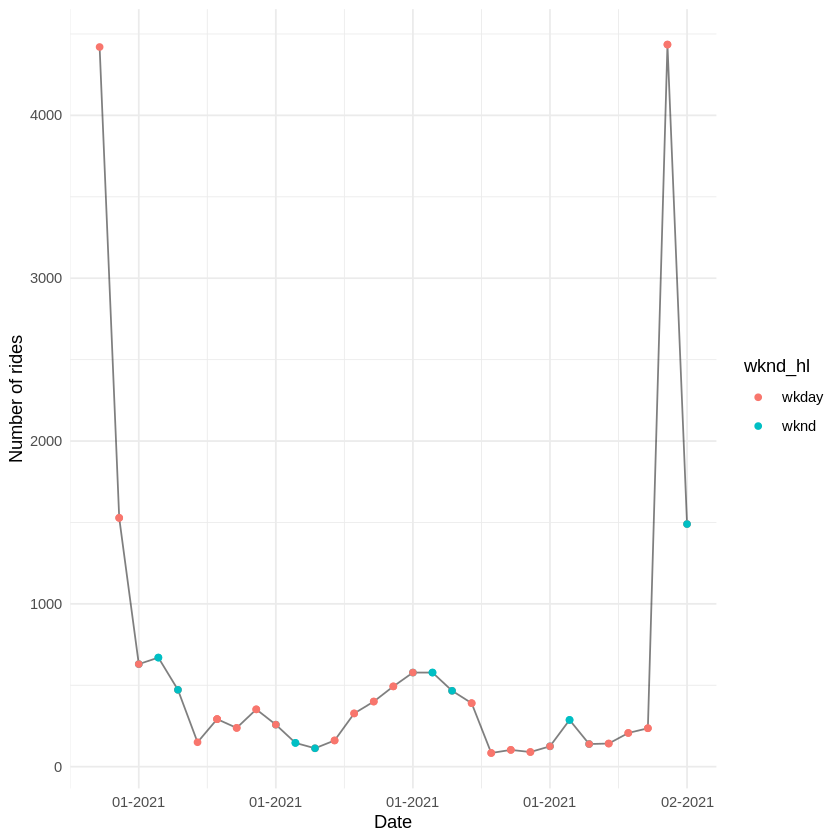

In [74]:
df_2021 %>% 
  group_by(modified_date_notime) %>%
  add_count() %>%
  select(modified_date_notime, n, day_of_week) %>%
  mutate(wknd_hl = if_else(day_of_week %in% c(0, 6), "wknd", "wkday")) %>%
  distinct() %>%
  #head()
  ggplot() + 
    geom_line(aes(x = modified_date_notime, y = n), alpha = 0.5) + 
    geom_point(aes(x = modified_date_notime, y = n, color = wknd_hl)) +
    scale_x_date(date_labels = "%m-%Y") +
    labs(
      x = "Date",
      y = "Number of rides"
      ) + 
    theme_minimal()

## Import Census/ACS data

In [97]:
# ACS Data
atx_tract <- tidycensus::get_acs(geography = "tract",
                          variables = "B19013_001", # income ?
                          state = "TX",
                          county = "Travis",
                          year = 2018,
                          survey = "acs5",
                          geometry = TRUE) %>% 
  select(GEOID, geometry)

Getting data from the 2014-2018 5-year ACS




Downloading: 3.8 MB     

### 2020

In [ ]:
df_2020 <- df_2020 %>% 
  # start point
  left_join(atx_tract, by = c("census_geoid_start"="GEOID")) %>% 
  rename(census_geom_start = geometry) %>% 
  # end point
  left_join(atx_tract, by = c("census_geoid_end"="GEOID")) %>% 
  rename(census_geom_end = geometry)

In [ ]:
df_2020 %>% head()

### 2021

In [124]:
df_2021 <- df_2021 %>% 
  # start point
  left_join(atx_tract, by = c("census_geoid_start"="GEOID")) %>% 
  rename(census_geom_start = geometry) %>% 
  # end point
  left_join(atx_tract, by = c("census_geoid_end"="GEOID")) %>% 
  rename(census_geom_end = geometry)

In [99]:
df_2021 %>% head()

,trip_id,device_id,vehicle_type,trip_duration,trip_distance,start_time,end_time,modified_date,month,hour,day_of_week,council_district_start,council_district_end,year,census_geoid_start,census_geoid_end,modified_date_notime,census_geom_start,census_geom_end
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<MULTIPOLYGON [°]>,<MULTIPOLYGON [°]>
1,a7a82917-3dc2-4de9-a56d-0c8546338e4e,fe344200-08eb-43ed-947e-0c60336761f8,scooter,898,862,2021-01-23T01:45:00.000,2021-01-23T02:00:00.000,2021-01-24T03:16:05.000,1,2,5,3,9,2021,48453000902,48453001100,2021-01-24,MULTIPOLYGON (((-97.73437 3...,MULTIPOLYGON (((-97.7509 30...
2,9e0d0984-e58d-4de7-af99-d879473ce30c,f19dc771-6e31-4715-84cd-0d6d8b66a10a,scooter,40,20,2021-01-14T00:15:00.000,2021-01-14T00:15:00.000,2021-01-15T02:17:24.000,1,0,3,9,9,2021,48453000700,48453000700,2021-01-15,MULTIPOLYGON (((-97.75212 3...,MULTIPOLYGON (((-97.75212 3...
3,a881bf88-a599-4f55-9748-04751454d0bf,81d570af-0a42-439d-acd0-fc7c42d13d0b,scooter,485,1966,2021-01-14T00:00:00.000,2021-01-14T00:15:00.000,2021-01-15T02:17:20.000,1,0,3,9,9,2021,48453001100,48453000700,2021-01-15,MULTIPOLYGON (((-97.7509 30...,MULTIPOLYGON (((-97.75212 3...
4,8e77f877-a6c0-4b35-a47f-f23b93cf391f,3f5a8dfc-4166-41a9-8513-f57fe728b290,scooter,612,1070,2021-01-14T00:00:00.000,2021-01-14T00:15:00.000,2021-01-15T02:17:19.000,1,0,3,3,3,2021,48453001000,48453000902,2021-01-15,MULTIPOLYGON (((-97.73717 3...,MULTIPOLYGON (((-97.73437 3...
5,b11b86e5-ef24-47db-ad0d-dac5ed25e019,2adbb5e5-7fa3-4115-8348-c1f689a22ebf,scooter,1097,5,2021-01-13T23:45:00.000,2021-01-14T00:15:00.000,2021-01-15T02:17:18.000,1,0,3,9,9,2021,48453001100,48453001100,2021-01-15,MULTIPOLYGON (((-97.7509 30...,MULTIPOLYGON (((-97.7509 30...
6,ed02d64c-a6ba-4c5a-98e3-61eef44304d9,16a28a75-0406-4f2c-b52d-761c4c8ef770,scooter,459,0,2021-01-14T00:00:00.000,2021-01-14T00:15:00.000,2021-01-15T02:17:18.000,1,0,3,9,9,2021,48453000603,48453000603,2021-01-15,MULTIPOLYGON (((-97.75331 3...,MULTIPOLYGON (((-97.75331 3...


## Maps

Function to create map

In [100]:
# FUNCTION get map data
get_map_data <- function(data,
                    start_date = "2021-01-18", 
                    end_date = "2021-01-18",
                    origin = TRUE,
                    vehicle_type = 0) {
  # 0 = all
  # 1 = bicycle
  # 2 = scooter
    
  data <- data %>%
    filter(str_detect(start_time, start_date) & str_detect(end_time, end_date))

  if (vehicle_type == 1) {
    data <- data %>% filter(vehicle_type == "bicycle")
  } else if (vehicle_type == 2) {
    data <- data %>% filter(vehicle_type == "scooter")
  } 
  
  if (origin == TRUE) {
    data <- data %>% 
      select(- census_geom_end) %>% 
      count(census_geoid_start) %>% 
      left_join(atx_tract, by = c("census_geoid_start"="GEOID")) 
  } else {
    data <- data %>% 
      select(- census_geom_start) %>% 
      count(census_geoid_end) %>% 
      left_join(atx_tract, by = c("census_geoid_end"="GEOID")) 
  }
  
  data <- data %>% rename(estimate = n)
  
  # make map
  return(data)
}

In [112]:
atx_map <- get_googlemap("austin, texas", zoom = 13, maptype = "roadmap") %>% 
           ggmap()

Source : https://maps.googleapis.com/maps/api/staticmap?center=austin,%20texas&zoom=13&size=640x640&scale=2&maptype=roadmap&key=xxx

Source : https://maps.googleapis.com/maps/api/geocode/json?address=austin,+texas&key=xxx



Coordinate system already present. Adding new coordinate system, which will replace the existing one.



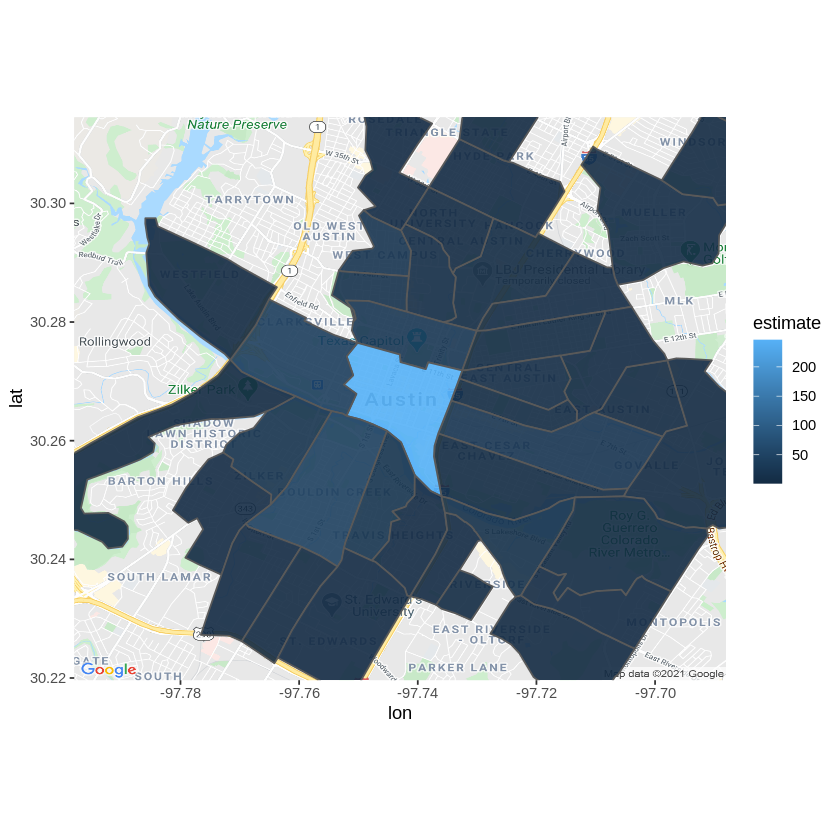

In [130]:
# 2021
df_2021_temp <- get_map_data(data = df_2021)

atx_map + 
  geom_sf(data = df_2021_temp, 
                     mapping = aes(geometry = geometry, fill = estimate), 
          alpha = 0.9,
          inherit.aes = FALSE) 